In [1]:
from mads_datasets.base import BaseDatastreamer
from mltrainer.preprocessors import BasePreprocessor
from pathlib import Path
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torch import nn
import torch
import numpy as np
import tomllib

from mads_hackathon import datasets, metrics

First, go to the `config.toml` file and change the `dev` value to your name. Please use `firstname_lastname` format. 
In addition to that, change the `port` value to the port of your team.

In [2]:

configfile = Path("config.toml")
with configfile.open("rb") as f:
    tomlconfig = tomllib.load(f)

assert tomlconfig["dev"] != "dev", ValueError("Please set dev in config.toml to your own name")
assert tomlconfig["port"] != "none", ValueError("Please set port in config.toml to your own port")
uri = tomlconfig["mlflow_uri"] + ":" + tomlconfig["port"]
dev = tomlconfig["dev"]
print(f"Using {uri} as mlfow uri")
print(f"Using {dev} as dev name")

Using http://145.38.195.42:5002 as mlfow uri
Using dev-youri as dev name


Load the datasets

In [3]:
datadir = Path('../hackathon-data/')
trainfile = (datadir / "heart_big_train.parq").resolve()
validfile = (datadir / "heart_big_valid.parq").resolve()
trainfile.exists(), validfile.exists()

(True, True)

Change the backend, if you have one.

In [4]:
import torch
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
    print("Using MPS")
elif torch.cuda.is_available():
    device = "cuda:0"
    print("using cuda")
else:
    device = "cpu"
    print("using cpu")

using cuda


Change the 1D data into a 2D matrix with the HeartDataset2D class. See `src/mads_hackathon/datasets.py` for more information.

In [5]:
matrixshape = (4, 48)
traindataset = datasets.HeartDataset2D(trainfile, target="target", shape=matrixshape)
testdataset = datasets.HeartDataset2D(validfile, target="target", shape=matrixshape)
traindataset.to(device)
testdataset.to(device)


Let's see how that works. 
Compare this to the 1D data from notebook `01_explore-heart.ipynb`

(torch.Size([1, 4, 48]), tensor(0, device='cuda:0'))

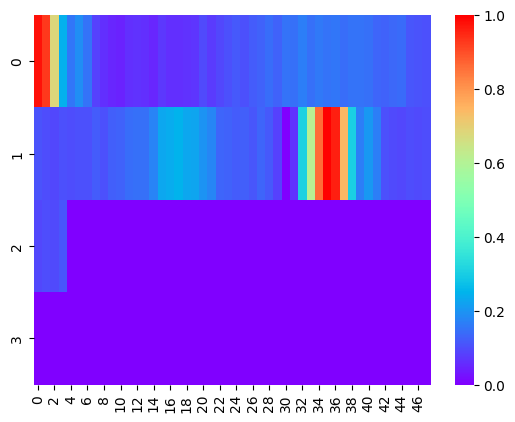

In [6]:
x, y = traindataset[0]
# Assuming your tensor is named 'tensor'
viz = x.squeeze().cpu().numpy()
sns.heatmap(viz, cmap='rainbow')
x.shape, y

First, we set the config, then load into a streamer

In [24]:
from mads_hackathon.models import CNNConfig as Config

# config = Config(
#     matrixshape = (4,48),
#     batchsize = 64,
#     input_channels = 1,
#     hidden = 16,
#     kernel_size = 3,
#     maxpool = 2,
#     num_layers = 1,
#     num_classes = 5,
# )
config = {
    "epochs": 1,
    "output_size": 20,
    "dev": "youri",
    "matrixshape": (4,48),
    "batchsize": 64,
    "input_channels": 1,
    "hidden": 16, # tune.randint(16, 128),
    "kernel_size": 3, # tune.randint(1, 12),
    "maxpool": 2, # tune.randint(1, 4),
    "num_layers": 1, # tune.randint(2, 5),
    "num_classes": 5, # tune.randint(2, 5),  
}
config

{'epochs': 1,
 'output_size': 20,
 'dev': 'youri',
 'matrixshape': (4, 48),
 'batchsize': 64,
 'input_channels': 1,
 'hidden': 16,
 'kernel_size': 3,
 'maxpool': 2,
 'num_layers': 1,
 'num_classes': 5}

In [ ]:
trainstreamer = BaseDatastreamer(traindataset, preprocessor = BasePreprocessor(), batchsize=config.batchsize)
teststreamer = BaseDatastreamer(testdataset, preprocessor = BasePreprocessor(), batchsize=config.batchsize)
len(trainstreamer), len(teststreamer)

(1368, 171)

Let's check the shape

In [15]:
x, y = next(trainstreamer.stream())
x.shape, y.shape

(torch.Size([64, 1, 4, 48]), torch.Size([64]))

We can load the CNN model. It uses a ConvBlock class that is a wrapper around a Conv2D and ReLU stack.
The ConvBlock makes it easier to stack block in the CNN model, see `src/mads_hackathon/models.py` for the implementation.

This is just a initial setup: please experiment with other architectures like:
- adding ideas like resnet, googlenet, squeeze-excite, etc.
- add additional layers like dropout, batchnorm, etc.
- experiment with different ways to go from 4D to 2D tensors

In [16]:
from mads_hackathon.models import CNN
model = CNN(config)

Calculated matrix size: 4
Caluclated flatten size: 64


Let's check the architecture

In [23]:
print(*config.matrixshape)

4 48


In [28]:
print(config["matrixshape"][0])

4


In [21]:
from torchinfo import summary
summary(model, input_size=(config.batchsize, 1, *config.matrixshape))

RuntimeError: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: [ConvBlock: 2, Sequential: 3, Conv2d: 4, ReLU: 4, Conv2d: 4, ReLU: 4, ConvBlock: 2, Sequential: 3, Conv2d: 4, ReLU: 4, Conv2d: 4, ReLU: 4, ReLU: 2, MaxPool2d: 2, Flatten: 2]

And test if the model works

In [19]:
model.to(device)
yhat = model(x)
yhat.shape

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x768 and 64x16)

The data is unbalanced, so we are interested in much more than just accuracy.
See https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html for more information on the F1 micro/macro score.
See `src/mads_hackathon/metrics.py` for the implementation. You might want to add more metrics, or change the settings for `average`

In [ ]:
f1micro = metrics.F1Score(average='micro')
f1macro = metrics.F1Score(average='macro')
precision = metrics.Precision(average='macro')
recall = metrics.Recall('macro')
accuracy = metrics.Accuracy()
print(f1micro)

F1scoremicro


We also want a confusion matrix to see how the model is performing on the different classes.

In [ ]:
from mads_hackathon.metrics import caluclate_cfm

We set the mlflow server to log the results

In [ ]:
import mlflow
mlflow.set_tracking_uri(uri)
mlflow.set_experiment("[NB-2] - youri")

2024/11/25 10:50:54 INFO mlflow.tracking.fluent: Experiment with name '[NB-2] - youri' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/698419473854768577', creation_time=1732528254077, experiment_id='698419473854768577', last_update_time=1732528254077, lifecycle_stage='active', name='[NB-2] - youri', tags={}>

In [ ]:
config = Config(
    matrixshape = (4,48),
    batchsize = 64,
    input_channels = 1,
    hidden = 16,
    kernel_size = 3,
    maxpool = 2,
    num_layers = 1,
    num_classes = 5,
)
config

CNNConfig(matrixshape=(4, 48), batchsize=64, input_channels=1, hidden=16, kernel_size=3, maxpool=2, num_layers=1, num_classes=5)

Please dont just run the cell below, but walk trough what is being logged.
For example, you might want to change the tag for the model and the dataset if you make changes there, and 
to the scheduler/earlystop if you are using it.

2024-11-25 10:50:54.227 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to logs/heart2D/20241125-105054
100%|██████████| 1368/1368 [00:05<00:00, 228.37it/s]
2024-11-25 10:51:01.244 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 0.3757 test 0.2503 metric ['0.9303', '0.9303', '0.6591', '0.9136', '0.6396']
100%|██████████| 1368/1368 [00:04<00:00, 339.78it/s]
2024-11-25 10:51:06.335 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.2213 test 0.2041 metric ['0.9454', '0.9454', '0.7498', '0.9053', '0.7453']
100%|██████████| 1368/1368 [00:04<00:00, 338.50it/s]
2024-11-25 10:51:11.449 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.1823 test 0.1727 metric ['0.9540', '0.9540', '0.7733', '0.9326', '0.7595']
100%|██████████| 1368/1368 [00:03<00:00, 342.70it/s]
2024-11-25 10:51:16.483 | INFO     | mltrainer.trainer:report:191 - Epoch 3 train 0.1591 test 0.1587 metric ['0.9586', '0.9586', '0.8108', '0.8955', '0.8248']
100%|██████████| 1368/1368 [00:04<

🏃 View run secretive-hawk-755 at: http://145.38.195.42:5002/#/experiments/698419473854768577/runs/6031758206c64289b37fb43456a6712f
🧪 View experiment at: http://145.38.195.42:5002/#/experiments/698419473854768577


[Text(0.5, 23.52222222222222, 'Predicted'),
 Text(50.722222222222214, 0.5, 'Target')]

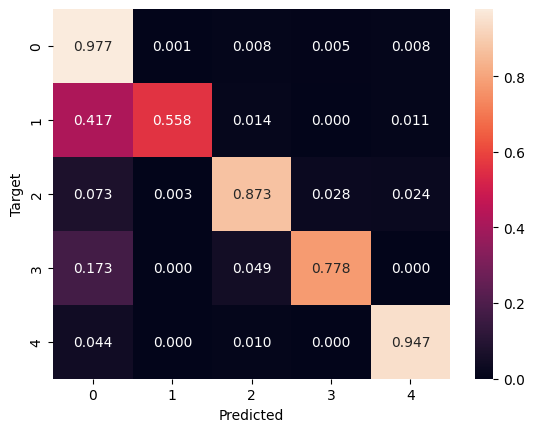

In [ ]:
from mltrainer import Trainer, TrainerSettings, ReportTypes
from dataclasses import asdict
loss_fn = torch.nn.CrossEntropyLoss()

with mlflow.start_run():
    optimizer = torch.optim.Adam

    settings = TrainerSettings(
        epochs=5,
        metrics=[accuracy, f1micro, f1macro, precision, recall],
        logdir="logs/heart2D",
        train_steps=len(trainstreamer),
        valid_steps=len(teststreamer),
        reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.MLFLOW],
        scheduler_kwargs=None,
        earlystop_kwargs=None
    )

    # modify the tags when you change them!
    mlflow.set_tag("model", "CNN")
    mlflow.set_tag("dataset", "heart2D")
    mlflow.set_tag("dev", dev)
    mlflow.log_param("scheduler", "None")
    mlflow.log_param("earlystop", "None")

    mlflow.log_params(asdict(config))
    mlflow.log_param("epochs", settings.epochs)
    mlflow.log_param("matrix0", config.matrixshape[0])
    mlflow.log_param("matrix1", config.matrixshape[1])
    mlflow.log_param("optimizer", str(optimizer))
    mlflow.log_params(settings.optimizer_kwargs)

    trainer = Trainer(
        model=model,
        settings=settings,
        loss_fn=loss_fn,
        optimizer=optimizer,
        traindataloader=trainstreamer.stream(),
        validdataloader=teststreamer.stream(),
        scheduler=None,
        device=device,
        )
    trainer.loop()
    cfm = caluclate_cfm(model, teststreamer)
    for i, tp in enumerate(np.diag(cfm)):
        mlflow.log_metric(f"TP_{i}", tp)

plot = sns.heatmap(cfm, annot=cfm, fmt=".3f")
plot.set(xlabel="Predicted", ylabel="Target")

Please note that, while the TP score for class 0 does get high without much effort, the challenge here will be in the other classes that lag behind.